In [2]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.1+cpu


In [3]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'E:\SnP Videos\covid19-radiography-database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

In [7]:
train_dirs = {
    'normal': r'E:\SnP Videos\COVID-19 Radiography Database\NORMAL',
    'viral': r'E:\SnP Videos\COVID-19 Radiography Database\Viral Pneumonia',
    'covid': r'E:\SnP Videos\COVID-19 Radiography Database\COVID-19'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 1113 covid examples


In [8]:
test_dirs = {
    'normal': r'E:\SnP Videos\COVID-19 Radiography Database\test\NORMAL',
    'viral': r'E:\SnP Videos\COVID-19 Radiography Database\test\Viral Pneumonia',
    'covid': r'E:\SnP Videos\COVID-19 Radiography Database\test\COVID-19'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [9]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Check Number of batches
print('Number of trainng batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of trainng batches 624
Number of test batches 15


In [10]:

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.455, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

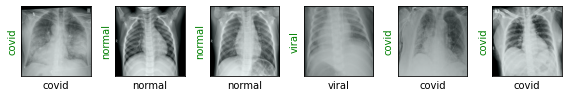

In [11]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

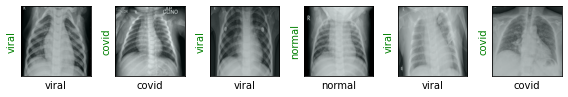

In [12]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [13]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [14]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [15]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

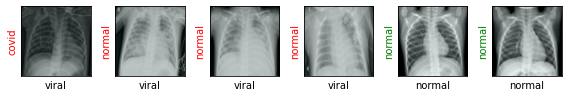

In [16]:
show_preds()

Starting training...
Starting epochs 1/1
Evaluating at step 0
Val loss: 1.2626, Acc: 0.3556


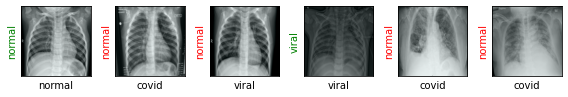

Evaluating at step 20
Val loss: 0.6875, Acc: 0.7667


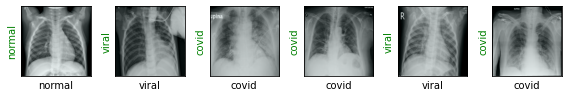

Evaluating at step 40
Val loss: 0.4578, Acc: 0.8778


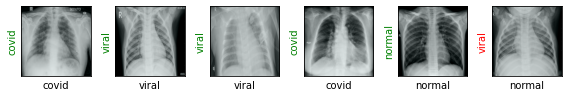

Evaluating at step 60
Val loss: 0.2729, Acc: 0.8889


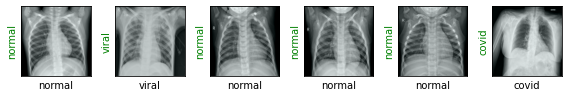

Evaluating at step 80
Val loss: 0.4374, Acc: 0.8222


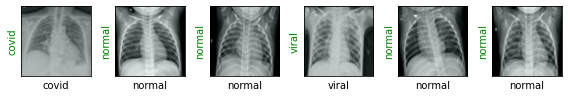

Evaluating at step 100
Val loss: 0.4220, Acc: 0.8667


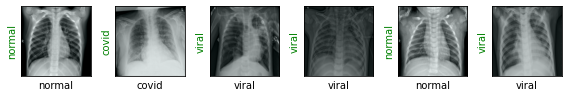

Evaluating at step 120
Val loss: 0.4067, Acc: 0.8556


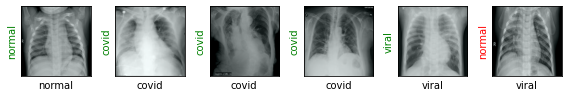

Evaluating at step 140
Val loss: 0.4945, Acc: 0.8222


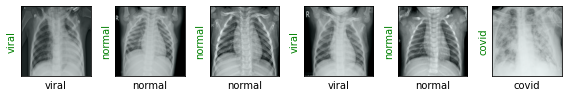

Evaluating at step 160
Val loss: 0.2697, Acc: 0.8778


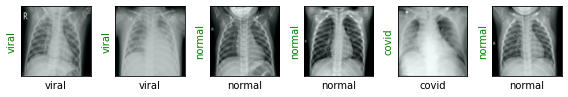

Evaluating at step 180
Val loss: 0.2269, Acc: 0.9444


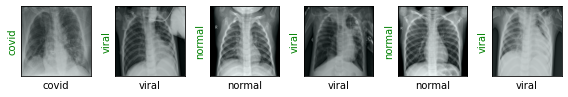

Evaluating at step 200
Val loss: 0.4100, Acc: 0.8778


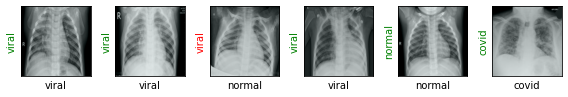

Evaluating at step 220
Val loss: 0.3720, Acc: 0.9000


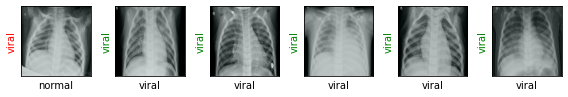

Evaluating at step 240
Val loss: 0.3055, Acc: 0.8889


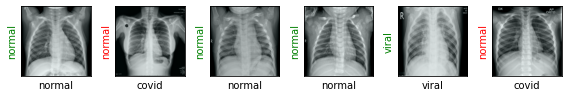

Evaluating at step 260
Val loss: 0.3127, Acc: 0.8778


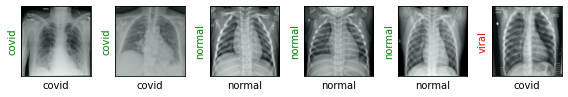

Evaluating at step 280
Val loss: 0.3378, Acc: 0.9333


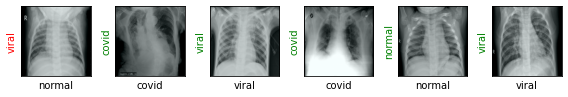

Evaluating at step 300
Val loss: 0.3941, Acc: 0.8889


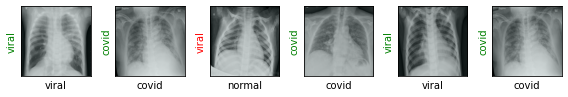

Evaluating at step 320
Val loss: 0.2188, Acc: 0.9111


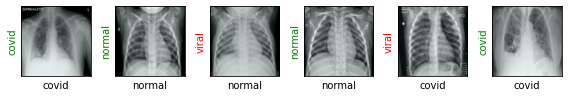

Evaluating at step 340
Val loss: 0.1786, Acc: 0.9556


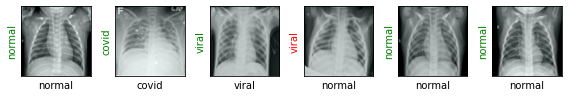

Perfomance condition satisfied!


In [19]:
train(epochs=1)

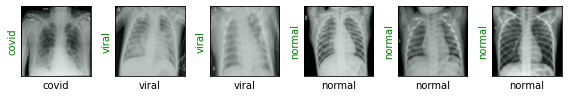

In [20]:
show_preds()

In [1]:
%pwd

'C:\\Users\\Asus'